In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm_notebook
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns



plt.style.use('seaborn')
sns.set(font_scale=1)

import gc

In [77]:
train = pd.read_csv("../input/landslide-prevention-and-innovation-challenge/Train (12).csv")
test = pd.read_csv("../input/landslide-prevention-and-innovation-challenge/Test (13).csv")
sample = pd.read_csv('../input/landslide-prevention-and-innovation-challenge/SampleSubmission (7).csv')

In [78]:
train["Label"].value_counts()

0    8148
1    2716
Name: Label, dtype: int64

In [79]:
train

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,...,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281729,1.281693,0
1,2,161,158,155,153,151,162,159,155,153,...,1.359639,1.359608,1.359587,1.359556,1.359683,1.359662,1.359631,1.359610,1.359579,1
2,3,149,151,154,156,158,154,157,158,160,...,1.365005,1.365025,1.365055,1.365075,1.364937,1.364967,1.364988,1.365018,1.365038,0
3,4,80,78,77,75,73,80,78,77,75,...,1.100708,1.100738,1.100759,1.100789,1.100630,1.100650,1.100680,1.100700,1.100731,0
4,5,117,115,114,112,110,115,113,111,110,...,1.284180,1.284130,1.284056,1.284006,1.284125,1.284050,1.284001,1.283926,1.283876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,10860,203,202,201,200,199,202,201,201,199,...,1.271912,1.272011,1.272076,1.272174,1.271720,1.271786,1.271884,1.271950,1.272048,0
10860,10861,432,430,427,423,421,431,429,426,422,...,1.331153,1.331137,1.331113,1.331096,1.331207,1.331183,1.331167,1.331142,1.331126,1
10861,10862,348,345,342,339,335,344,342,339,336,...,1.298362,1.298337,1.298321,1.298297,1.298392,1.298376,1.298352,1.298336,1.298311,1
10862,10863,93,91,90,88,86,96,94,93,92,...,1.355035,1.355061,1.355099,1.355125,1.354937,1.354976,1.355002,1.355041,1.355067,0


In [80]:
id_=test["Sample_ID"]
test.drop("Sample_ID", axis=1, inplace=True)
train.drop("Sample_ID", axis=1, inplace=True)

In [81]:
col=train.columns[:-1]

In [82]:
col

Index(['1_elevation', '2_elevation', '3_elevation', '4_elevation',
       '5_elevation', '6_elevation', '7_elevation', '8_elevation',
       '9_elevation', '10_elevation',
       ...
       '16_sdoif', '17_sdoif', '18_sdoif', '19_sdoif', '20_sdoif', '21_sdoif',
       '22_sdoif', '23_sdoif', '24_sdoif', '25_sdoif'],
      dtype='object', length=225)

In [83]:
def calc_total(name,DataFrame):
    DataFrame['total_'+name] = 0
    for i in range(1,26):
        DataFrame['total_'+name] +=  DataFrame[str(i)+'_'+name]
    return DataFrame
train=calc_total('slope',train)
test=calc_total('slope',test)
train=calc_total('elevation',train)
test=calc_total('elevation',test)
train=calc_total('sdoif',train)
test=calc_total('sdoif',test)
train=calc_total('lsfactor',train)
test=calc_total('lsfactor',test)
train=calc_total('twi',train)
test=calc_total('twi',test)
train=calc_total('placurv',train)
test=calc_total('placurv',test)
train=calc_total('procurv',train)
test=calc_total('procurv',test)

train.head(10)

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,...,24_sdoif,25_sdoif,Label,total_slope,total_elevation,total_sdoif,total_lsfactor,total_twi,total_placurv,total_procurv
0,130,129,127,126,123,126,125,124,122,119,...,1.281729,1.281693,0,920.759220,2986,32.043332,225.342353,86.662827,0.316465,-0.222866
1,161,158,155,153,151,162,159,155,153,151,...,1.359610,1.359579,1,713.116670,3905,33.989444,200.345615,116.513413,0.266576,-0.095545
2,149,151,154,156,158,154,157,158,160,161,...,1.365018,1.365038,0,958.406450,4064,34.126354,273.950444,105.694982,0.702151,0.561299
3,80,78,77,75,73,80,78,77,75,73,...,1.100700,1.100731,0,481.782970,1910,27.520452,94.642992,93.446023,0.726599,0.222366
4,117,115,114,112,110,115,113,111,110,108,...,1.283926,1.283876,0,706.448440,2729,32.105513,193.563024,113.551492,-0.114302,-0.191980
5,308,310,314,317,319,303,307,310,313,315,...,1.325647,1.325583,1,902.150370,7670,33.145168,232.224687,95.473527,-0.739196,-0.378038
6,130,130,130,130,129,132,132,132,132,132,...,1.321152,1.321097,0,400.763856,3276,33.035228,65.038096,105.237826,0.266396,0.079556
7,141,139,137,135,132,143,141,139,136,133,...,1.287928,1.287892,0,721.340640,3491,32.199448,158.709341,83.868949,0.378994,0.327065
8,100,102,104,106,109,100,102,104,107,109,...,1.303178,1.303169,0,583.689600,2602,32.577881,221.857850,164.899133,-0.161406,-0.001375
9,141,140,140,140,140,143,143,143,144,144,...,1.299168,1.299124,0,833.931620,3668,32.479377,227.285501,104.631095,-0.246812,0.012332


In [84]:
train

,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,...,24_sdoif,25_sdoif,Label,total_slope,total_elevation,total_sdoif,total_lsfactor,total_twi,total_placurv,total_procurv
0,130,129,127,126,123,126,125,124,122,119,...,1.281729,1.281693,0,920.75922,2986,32.043332,225.342353,86.662827,0.316465,-0.222866
1,161,158,155,153,151,162,159,155,153,151,...,1.359610,1.359579,1,713.11667,3905,33.989444,200.345615,116.513413,0.266576,-0.095545
2,149,151,154,156,158,154,157,158,160,161,...,1.365018,1.365038,0,958.40645,4064,34.126354,273.950444,105.694982,0.702151,0.561299
3,80,78,77,75,73,80,78,77,75,73,...,1.100700,1.100731,0,481.78297,1910,27.520452,94.642992,93.446023,0.726599,0.222366
4,117,115,114,112,110,115,113,111,110,108,...,1.283926,1.283876,0,706.44844,2729,32.105513,193.563024,113.551492,-0.114302,-0.191980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,203,202,201,200,199,202,201,201,199,198,...,1.271950,1.272048,0,508.04206,4951,31.804527,100.995544,100.050349,0.296114,-0.028225
10860,432,430,427,423,421,431,429,426,422,419,...,1.331142,1.331126,1,716.82772,10608,33.277350,161.248950,87.047270,0.488365,0.314391
10861,348,345,342,339,335,344,342,339,336,332,...,1.298336,1.298311,1,1004.04055,8386,32.457962,269.376987,93.207612,0.084477,0.111389
10862,93,91,90,88,86,96,94,93,92,91,...,1.355041,1.355067,0,884.26882,2416,33.878612,229.587868,95.055997,-0.043397,0.310983


In [85]:
train["elevation_median"]=train[train.columns[:25].to_list()].median(axis=1)
train["slope_median"]=train[train.columns[25:50].to_list()].median(axis=1)
train["aspect_median"]=train[train.columns[50:75].to_list()].median(axis=1)
train["placurv_median"]=train[train.columns[75:100].to_list()].median(axis=1)
train["procurv_median"]=train[train.columns[100:125].to_list()].median(axis=1)
train["lsfactor_median"]=train[train.columns[125:150].to_list()].median(axis=1)
train["twi_median"]=train[train.columns[150:175].to_list()].median(axis=1)
train["geology_median"]=train[train.columns[175:200].to_list()].median(axis=1)
train["sdoif_median"]=train[train.columns[200:225].to_list()].median(axis=1)
#################################################################
train["elevation_mean"]=train[train.columns[:25].to_list()].mean(axis=1)
train["slope_mean"]=train[train.columns[25:50].to_list()].mean(axis=1)
train["aspect_mean"]=train[train.columns[50:75].to_list()].mean(axis=1)
train["placurv_mean"]=train[train.columns[75:100].to_list()].mean(axis=1)
train["procurv_mean"]=train[train.columns[100:125].to_list()].mean(axis=1)
train["lsfactor_mean"]=train[train.columns[125:150].to_list()].mean(axis=1)
train["twi_mean"]=train[train.columns[150:175].to_list()].mean(axis=1)
train["geology_mean"]=train[train.columns[175:200].to_list()].mean(axis=1)
train["sdoif_mean"]=train[train.columns[200:225].to_list()].mean(axis=1)
########################################################################
train["elevation_count"]=train[train.columns[:25].to_list()].count(axis=1)
train["slope_count"]=train[train.columns[25:50].to_list()].count(axis=1)
train["aspect_count"]=train[train.columns[50:75].to_list()].count(axis=1)
train["placurv_count"]=train[train.columns[75:100].to_list()].count(axis=1)
train["procurv_count"]=train[train.columns[100:125].to_list()].count(axis=1)
train["lsfactor_count"]=train[train.columns[125:150].to_list()].count(axis=1)
train["twi_count"]=train[train.columns[150:175].to_list()].count(axis=1)
train["geology_count"]=train[train.columns[175:200].to_list()].count(axis=1)
train["sdoif_count"]=train[train.columns[200:225].to_list()].count(axis=1)
#########################################################################
train["elevation_std"]=train[train.columns[:25].to_list()].std(axis=1)
train["slope_std"]=train[train.columns[25:50].to_list()].std(axis=1)
train["aspect_std"]=train[train.columns[50:75].to_list()].std(axis=1)
train["placurv_std"]=train[train.columns[75:100].to_list()].std(axis=1)
train["procurv_std"]=train[train.columns[100:125].to_list()].std(axis=1)
train["lsfactor_std"]=train[train.columns[125:150].to_list()].std(axis=1)
train["twi_std"]=train[train.columns[150:175].to_list()].std(axis=1)
train["geology_std"]=train[train.columns[175:200].to_list()].std(axis=1)
train["sdoif_std"]=train[train.columns[200:225].to_list()].std(axis=1)
#########################################################################
train["elevation_min"]=train[train.columns[:25].to_list()].min(axis=1)
train["slope_min"]=train[train.columns[25:50].to_list()].min(axis=1)
train["aspect_min"]=train[train.columns[50:75].to_list()].min(axis=1)
train["placurv_min"]=train[train.columns[75:100].to_list()].min(axis=1)
train["procurv_min"]=train[train.columns[100:125].to_list()].min(axis=1)
train["lsfactor_min"]=train[train.columns[125:150].to_list()].min(axis=1)
train["twi_min"]=train[train.columns[150:175].to_list()].min(axis=1)
train["geology_min"]=train[train.columns[175:200].to_list()].min(axis=1)
train["sdoif_min"]=train[train.columns[200:225].to_list()].min(axis=1)
#########################################################################
train["elevation_max"]=train[train.columns[:25].to_list()].max(axis=1)
train["slope_max"]=train[train.columns[25:50].to_list()].max(axis=1)
train["aspect_max"]=train[train.columns[50:75].to_list()].max(axis=1)
train["placurv_max"]=train[train.columns[75:100].to_list()].max(axis=1)
train["procurv_max"]=train[train.columns[100:125].to_list()].max(axis=1)
train["lsfactor_max"]=train[train.columns[125:150].to_list()].max(axis=1)
train["twi_max"]=train[train.columns[150:175].to_list()].max(axis=1)
train["geology_max"]=train[train.columns[175:200].to_list()].max(axis=1)
train["sdoif_max"]=train[train.columns[200:225].to_list()].max(axis=1)
#########################################################################
train["elevation_kurt"]=train[train.columns[:25].to_list()].kurt(axis=1)
train["slope_kurt"]=train[train.columns[25:50].to_list()].kurt(axis=1)
train["aspect_kurt"]=train[train.columns[50:75].to_list()].kurt(axis=1)
train["placurv_kurt"]=train[train.columns[75:100].to_list()].kurt(axis=1)
train["procurv_kurt"]=train[train.columns[100:125].to_list()].kurt(axis=1)
train["lsfactor_kurt"]=train[train.columns[125:150].to_list()].kurt(axis=1)
train["twi_kurt"]=train[train.columns[150:175].to_list()].kurt(axis=1)
train["geology_kurt"]=train[train.columns[175:200].to_list()].kurt(axis=1)
train["sdoif_kurt"]=train[train.columns[200:225].to_list()].kurt(axis=1)
#########################################################################
train["elevation_skew"]=train[train.columns[:25].to_list()].skew(axis=1)
train["slope_skew"]=train[train.columns[25:50].to_list()].skew(axis=1)
train["aspect_skew"]=train[train.columns[50:75].to_list()].skew(axis=1)
train["placurv_skew"]=train[train.columns[75:100].to_list()].skew(axis=1)
train["procurv_skew"]=train[train.columns[100:125].to_list()].skew(axis=1)
train["lsfactor_skew"]=train[train.columns[125:150].to_list()].skew(axis=1)
train["twi_skew"]=train[train.columns[150:175].to_list()].skew(axis=1)
train["geology_skew"]=train[train.columns[175:200].to_list()].skew(axis=1)
train["sdoif_skew"]=train[train.columns[200:225].to_list()].skew(axis=1)
#########################################################################
train["elevation_q7.5"]=train[train.columns[:25].to_list()].quantile(q=0.75,axis=1)
train["slope_q7.5"]=train[train.columns[25:50].to_list()].quantile(q=0.75,axis=1)
train["aspect_q7.5"]=train[train.columns[50:75].to_list()].quantile(q=0.75,axis=1)
train["placurv_q7.5"]=train[train.columns[75:100].to_list()].quantile(q=0.75,axis=1)
train["procurv_q7.5"]=train[train.columns[100:125].to_list()].quantile(q=0.75,axis=1)
train["lsfactor_q7.5"]=train[train.columns[125:150].to_list()].quantile(q=0.75,axis=1)
train["twi_q7.5"]=train[train.columns[150:175].to_list()].quantile(q=0.75,axis=1)
train["geology_q7.5"]=train[train.columns[175:200].to_list()].quantile(q=0.75,axis=1)
train["sdoif_q7.5"]=train[train.columns[200:225].to_list()].quantile(q=0.75,axis=1)
#########################################################################
train["elevation_q5"]=train[train.columns[:25].to_list()].quantile(q=0.5,axis=1)
train["slope_q5"]=train[train.columns[25:50].to_list()].quantile(q=0.5,axis=1)
train["aspect_q5"]=train[train.columns[50:75].to_list()].quantile(q=0.5,axis=1)
train["placurv_q5"]=train[train.columns[75:100].to_list()].quantile(q=0.5,axis=1)
train["procurv_q5"]=train[train.columns[100:125].to_list()].quantile(q=0.5,axis=1)
train["lsfactor_q5"]=train[train.columns[125:150].to_list()].quantile(q=0.5,axis=1)
train["twi_q5"]=train[train.columns[150:175].to_list()].quantile(q=0.5,axis=1)
train["geology_q5"]=train[train.columns[175:200].to_list()].quantile(q=0.5,axis=1)
train["sdoif_q5"]=train[train.columns[200:225].to_list()].quantile(q=0.5,axis=1)
#########################################################################
train["elevation_q2.5"]=train[train.columns[:25].to_list()].quantile(q=0.25,axis=1)
train["slope_q2.5"]=train[train.columns[25:50].to_list()].quantile(q=0.25,axis=1)
train["aspect_q2.5"]=train[train.columns[50:75].to_list()].quantile(q=0.25,axis=1)
train["placurv_q2.5"]=train[train.columns[75:100].to_list()].quantile(q=0.25,axis=1)
train["procurv_q2.5"]=train[train.columns[100:125].to_list()].quantile(q=0.25,axis=1)
train["lsfactor_q2.5"]=train[train.columns[125:150].to_list()].quantile(q=0.25,axis=1)
train["twi_q2.5"]=train[train.columns[150:175].to_list()].quantile(q=0.25,axis=1)
train["geology_q2.5"]=train[train.columns[175:200].to_list()].quantile(q=0.25,axis=1)
train["sdoif_q2.5"]=train[train.columns[200:225].to_list()].quantile(q=0.25,axis=1)
#########################################################################
train.drop(col, axis=1, inplace=True)

In [86]:
train

,Label,total_slope,total_elevation,total_sdoif,total_lsfactor,total_twi,total_placurv,total_procurv,elevation_median,slope_median,...,sdoif_q5,elevation_q2.5,slope_q2.5,aspect_q2.5,placurv_q2.5,procurv_q2.5,lsfactor_q2.5,twi_q2.5,geology_q2.5,sdoif_q2.5
0,0,920.75922,2986,32.043332,225.342353,86.662827,0.316465,-0.222866,119.0,36.05503,...,1.281730,115.0,33.85452,113.1986,0.005337,-0.023553,8.045186,3.154479,3.0,1.281698
1,1,713.11667,3905,33.989444,200.345615,116.513413,0.266576,-0.095545,156.0,27.01712,...,1.359579,153.0,26.56505,180.0000,0.005583,-0.008197,7.111054,4.441799,3.0,1.359547
2,0,958.40645,4064,34.126354,273.950444,105.694982,0.702151,0.561299,164.0,36.05503,...,1.365055,158.0,31.31116,270.0000,0.013423,0.008324,9.387614,3.363745,2.0,1.365018
3,0,481.78297,1910,27.520452,94.642992,93.446023,0.726599,0.222366,77.0,17.54840,...,1.100826,75.0,16.69924,161.5650,0.022927,0.005753,3.194233,3.467204,2.0,1.100731
4,0,706.44844,2729,32.105513,193.563024,113.551492,-0.114302,-0.191980,109.0,29.49621,...,1.284222,106.0,26.56505,120.9638,-0.009951,-0.010910,7.337839,4.083162,2.0,1.284092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,0,508.04206,4951,31.804527,100.995544,100.050349,0.296114,-0.028225,198.0,19.82703,...,1.272174,196.0,15.79317,111.8014,0.002935,-0.016208,2.524856,3.677230,2.0,1.272011
10860,1,716.82772,10608,33.277350,161.248950,87.047270,0.488365,0.314391,424.0,27.01712,...,1.331096,421.0,26.56505,135.0000,0.009280,0.007461,5.375127,3.211934,3.0,1.331052
10861,1,1004.04055,8386,32.457962,269.376987,93.207612,0.084477,0.111389,336.0,40.31554,...,1.298319,332.0,37.99073,130.6013,-0.010156,-0.003635,10.294480,3.254569,3.0,1.298297
10862,0,884.26882,2416,33.878612,229.587868,95.055997,-0.043397,0.310983,97.0,35.26439,...,1.355141,93.0,33.85452,243.4350,-0.014070,0.003979,8.591082,3.384373,2.0,1.355061


In [87]:
test["elevation_median"]=train[train.columns[:25].to_list()].median(axis=1)
test["slope_median"]=train[train.columns[25:50].to_list()].median(axis=1)
test["aspect_median"]=train[train.columns[50:75].to_list()].median(axis=1)
test["placurv_median"]=train[train.columns[75:100].to_list()].median(axis=1)
test["procurv_median"]=train[train.columns[100:125].to_list()].median(axis=1)
test["lsfactor_median"]=train[train.columns[125:150].to_list()].median(axis=1)
test["twi_median"]=train[train.columns[150:175].to_list()].median(axis=1)
test["geology_median"]=train[train.columns[175:200].to_list()].median(axis=1)
test["sdoif_median"]=train[train.columns[200:225].to_list()].median(axis=1)
#################################################################
test["elevation_mean"]=test[test.columns[:25].to_list()].mean(axis=1)
test["slope_mean"]=test[test.columns[25:50].to_list()].mean(axis=1)
test["aspect_mean"]=test[test.columns[50:75].to_list()].mean(axis=1)
test["placurv_mean"]=test[test.columns[75:100].to_list()].mean(axis=1)
test["procurv_mean"]=test[test.columns[100:125].to_list()].mean(axis=1)
test["lsfactor_mean"]=test[test.columns[125:150].to_list()].mean(axis=1)
test["twi_mean"]=test[test.columns[150:175].to_list()].mean(axis=1)
test["geology_mean"]=test[test.columns[175:200].to_list()].mean(axis=1)
test["sdoif_mean"]=test[test.columns[200:225].to_list()].mean(axis=1)
########################################################################
test["elevation_count"]=test[test.columns[:25].to_list()].count(axis=1)
test["slope_count"]=test[test.columns[25:50].to_list()].count(axis=1)
test["aspect_count"]=test[test.columns[50:75].to_list()].count(axis=1)
test["placurv_count"]=test[test.columns[75:100].to_list()].count(axis=1)
test["procurv_count"]=test[test.columns[100:125].to_list()].count(axis=1)
test["lsfactor_count"]=test[test.columns[125:150].to_list()].count(axis=1)
test["twi_count"]=test[test.columns[150:175].to_list()].count(axis=1)
test["geology_count"]=test[test.columns[175:200].to_list()].count(axis=1)
test["sdoif_count"]=test[test.columns[200:225].to_list()].count(axis=1)
#########################################################################
test["elevation_std"]=test[test.columns[:25].to_list()].std(axis=1)
test["slope_std"]=test[test.columns[25:50].to_list()].std(axis=1)
test["aspect_std"]=test[test.columns[50:75].to_list()].std(axis=1)
test["placurv_std"]=test[test.columns[75:100].to_list()].std(axis=1)
test["procurv_std"]=test[test.columns[100:125].to_list()].std(axis=1)
test["lsfactor_std"]=test[test.columns[125:150].to_list()].std(axis=1)
test["twi_std"]=test[test.columns[150:175].to_list()].std(axis=1)
test["geology_std"]=test[test.columns[175:200].to_list()].std(axis=1)
test["sdoif_std"]=test[test.columns[200:225].to_list()].std(axis=1)
#########################################################################
test["elevation_min"]=test[test.columns[:25].to_list()].min(axis=1)
test["slope_min"]=test[test.columns[25:50].to_list()].min(axis=1)
test["aspect_min"]=test[test.columns[50:75].to_list()].min(axis=1)
test["placurv_min"]=test[test.columns[75:100].to_list()].min(axis=1)
test["procurv_min"]=test[test.columns[100:125].to_list()].min(axis=1)
test["lsfactor_min"]=test[test.columns[125:150].to_list()].min(axis=1)
test["twi_min"]=test[test.columns[150:175].to_list()].min(axis=1)
test["geology_min"]=test[test.columns[175:200].to_list()].min(axis=1)
test["sdoif_min"]=test[test.columns[200:225].to_list()].min(axis=1)
#########################################################################
test["elevation_max"]=test[test.columns[:25].to_list()].max(axis=1)
test["slope_max"]=test[test.columns[25:50].to_list()].max(axis=1)
test["aspect_max"]=test[test.columns[50:75].to_list()].max(axis=1)
test["placurv_max"]=test[test.columns[75:100].to_list()].max(axis=1)
test["procurv_max"]=test[test.columns[100:125].to_list()].max(axis=1)
test["lsfactor_max"]=test[test.columns[125:150].to_list()].max(axis=1)
test["twi_max"]=test[test.columns[150:175].to_list()].max(axis=1)
test["geology_max"]=test[test.columns[175:200].to_list()].max(axis=1)
test["sdoif_max"]=test[test.columns[200:225].to_list()].max(axis=1)
#########################################################################
test["elevation_kurt"]=test[test.columns[:25].to_list()].kurt(axis=1)
test["slope_kurt"]=test[test.columns[25:50].to_list()].kurt(axis=1)
test["aspect_kurt"]=test[test.columns[50:75].to_list()].kurt(axis=1)
test["placurv_kurt"]=test[test.columns[75:100].to_list()].kurt(axis=1)
test["procurv_kurt"]=test[test.columns[100:125].to_list()].kurt(axis=1)
test["lsfactor_kurt"]=test[test.columns[125:150].to_list()].kurt(axis=1)
test["twi_kurt"]=test[test.columns[150:175].to_list()].kurt(axis=1)
test["geology_kurt"]=test[test.columns[175:200].to_list()].kurt(axis=1)
test["sdoif_kurt"]=test[test.columns[200:225].to_list()].kurt(axis=1)
#########################################################################
test["elevation_skew"]=test[test.columns[:25].to_list()].skew(axis=1)
test["slope_skew"]=test[test.columns[25:50].to_list()].skew(axis=1)
test["aspect_skew"]=test[test.columns[50:75].to_list()].skew(axis=1)
test["placurv_skew"]=test[test.columns[75:100].to_list()].skew(axis=1)
test["procurv_skew"]=test[test.columns[100:125].to_list()].skew(axis=1)
test["lsfactor_skew"]=test[test.columns[125:150].to_list()].skew(axis=1)
test["twi_skew"]=test[test.columns[150:175].to_list()].skew(axis=1)
test["geology_skew"]=test[test.columns[175:200].to_list()].skew(axis=1)
test["sdoif_skew"]=test[test.columns[200:225].to_list()].skew(axis=1)
#########################################################################
test["elevation_q7.5"]=test[test.columns[:25].to_list()].quantile(q=0.75,axis=1)
test["slope_q7.5"]=test[test.columns[25:50].to_list()].quantile(q=0.75,axis=1)
test["aspect_q7.5"]=test[test.columns[50:75].to_list()].quantile(q=0.75,axis=1)
test["placurv_q7.5"]=test[test.columns[75:100].to_list()].quantile(q=0.75,axis=1)
test["procurv_q7.5"]=test[test.columns[100:125].to_list()].quantile(q=0.75,axis=1)
test["lsfactor_q7.5"]=test[test.columns[125:150].to_list()].quantile(q=0.75,axis=1)
test["twi_q7.5"]=test[test.columns[150:175].to_list()].quantile(q=0.75,axis=1)
test["geology_q7.5"]=test[test.columns[175:200].to_list()].quantile(q=0.75,axis=1)
test["sdoif_q7.5"]=test[test.columns[200:225].to_list()].quantile(q=0.75,axis=1)
#########################################################################
test["elevation_q5"]=test[test.columns[:25].to_list()].quantile(q=0.5,axis=1)
test["slope_q5"]=test[test.columns[25:50].to_list()].quantile(q=0.5,axis=1)
test["aspect_q5"]=test[test.columns[50:75].to_list()].quantile(q=0.5,axis=1)
test["placurv_q5"]=test[test.columns[75:100].to_list()].quantile(q=0.5,axis=1)
test["procurv_q5"]=test[test.columns[100:125].to_list()].quantile(q=0.5,axis=1)
test["lsfactor_q5"]=test[test.columns[125:150].to_list()].quantile(q=0.5,axis=1)
test["twi_q5"]=test[test.columns[150:175].to_list()].quantile(q=0.5,axis=1)
test["geology_q5"]=test[test.columns[175:200].to_list()].quantile(q=0.5,axis=1)
test["sdoif_q5"]=test[test.columns[200:225].to_list()].quantile(q=0.5,axis=1)
#########################################################################
test["elevation_q2.5"]=test[test.columns[:25].to_list()].quantile(q=0.25,axis=1)
test["slope_q2.5"]=test[test.columns[25:50].to_list()].quantile(q=0.25,axis=1)
test["aspect_q2.5"]=test[test.columns[50:75].to_list()].quantile(q=0.25,axis=1)
test["placurv_q2.5"]=test[test.columns[75:100].to_list()].quantile(q=0.25,axis=1)
test["procurv_q2.5"]=test[test.columns[100:125].to_list()].quantile(q=0.25,axis=1)
test["lsfactor_q2.5"]=test[test.columns[125:150].to_list()].quantile(q=0.25,axis=1)
test["twi_q2.5"]=test[test.columns[150:175].to_list()].quantile(q=0.25,axis=1)
test["geology_q2.5"]=test[test.columns[175:200].to_list()].quantile(q=0.25,axis=1)
test["sdoif_q2.5"]=test[test.columns[200:225].to_list()].quantile(q=0.25,axis=1)
#########################################################################
test.drop(col, axis=1, inplace=True)

In [88]:
train.shape , test.shape

((10864, 107), (5430, 106))

In [89]:
y_train = train[['Label']]
df_train=train.drop(['Label'], axis=1)
cols=df_train.columns

In [90]:
# from sklearn.decomposition import PCA
# pca = PCA()
# df_train = pca.fit_transform(df_train)
# test = pca.fit_transform(test)
# df_train = df_train[:, :15]
# test = test[:, :15]
# df_train = pd.DataFrame(df_train, columns=train.columns[:15])
# test = pd.DataFrame(test, columns=train.columns[:15])

In [91]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
df_train = pd.DataFrame(ss.fit_transform(df_train), columns=df_train.columns)
test = pd.DataFrame(ss.transform(test), columns=test.columns)


In [92]:
# from imblearn.over_sampling import RandomOverSampler
# sampler = RandomOverSampler(random_state=11)
# from imblearn.over_sampling import SMOTE
# # sampler = SMOTE(k_neighbors=5, random_state=11)
# from imblearn.over_sampling import BorderlineSMOTE
# sampler = BorderlineSMOTE(k_neighbors=5, random_state=11)
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=11)

In [93]:
df_train.shape

(10864, 106)

In [94]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
fold=StratifiedKFold(n_splits=5)#15#5#10
i=1
from sklearn.model_selection import KFold,StratifiedKFold ,GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn import  ensemble
def get_model(Name='lgbm') :
    if Name=='lgbm' :
      return LGBMClassifier(**{ 'boosting_type': 'gbdt','objective': 'binary','metric': 'auc',
                                'n_estimators': 500,'colsample_bytree' : 0.8,
                                'seed': 42,'silent':False,
                                'early_stopping_rounds': 100,
                                'learning_rate' : 0.05,'num_iterations': 1500,
                                'max_depth' :8 ,'num_leaves' : 150,
                                'max_bins': 85,'min_data_in_leaf':30 })
cols=test.columns
test_ = test[cols]
Model_Name = "lgbm"
folds = StratifiedKFold(n_splits=15, shuffle=True, random_state=5168)
oofss  = np.zeros((len(df_train[cols])))
tstpred = np.zeros((len(test)))
tst_predd =  np.zeros((len(test)))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, train[['Label']])):
    X_train, y_train = df_train.iloc[trn_idx][cols], train.iloc[trn_idx]['Label']
    X_valid, y_valid = df_train.iloc[val_idx][cols], train.iloc[val_idx]['Label']
#     X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
#     X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    X_train ,y_train = sampler.fit_resample(X_train ,y_train)
    
#     clf = get_model(Name=Model_Name)
#     clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)],
#             verbose =100, early_stopping_rounds = 500)
    m2  = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.1,
                              bootstrap_type='Bernoulli',metric_period=100,max_depth = 8,
                     use_best_model=True)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid, y_valid)], early_stopping_rounds=200,verbose=100,)

    
    vp = m2.predict(X_valid)
    oofss[val_idx] = vp
    val_score = mean_squared_error((vp), (y_valid),squared=True)
    print(4*'-- -- -- --')
    print(f'Fold {fold_+1} Val score: {val_score}')
    print(4*'-- -- -- --')
    
    tp = m2.predict(test_)
    tstpred += tp / folds.n_splits

  
print()
print(3*'###',10*"^",3*'###')
print(mean_squared_error(train["Label"], oofss,squared=True))
print("Model training")
# clf.fit(X_train, y_train )

0:	learn: 0.7571992	test: 0.7571992	test1: 0.6620690	best: 0.6620690 (0)	total: 187ms	remaining: 2m 29s
100:	learn: 0.9368836	test: 0.9368836	test1: 0.7710345	best: 0.7751724 (74)	total: 8.18s	remaining: 56.6s
200:	learn: 0.9944773	test: 0.9944773	test1: 0.7779310	best: 0.7834483 (117)	total: 15.9s	remaining: 47.3s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8193103	best: 0.8234483 (326)	total: 31.1s	remaining: 31s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.8206897	best: 0.8234483 (326)	total: 38.4s	remaining: 22.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8234482759
bestIteration = 326

Shrink model to first 327 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 4 Val score: 0.17655172413793102
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7564103	test: 0.7564103	test1: 0.7168508	best: 0.7168508 (0)	total: 125ms	remaining: 1m 39s
100:	learn: 0.9341223	test: 0.9341223	test1: 0.7914365	best: 0.8024862 (70)	total: 7.77s	remaining: 53.8s
200:	learn: 0.9960552	test: 0.9960552	test1: 0.8066298	best: 0.8093923 (161)	total: 16.3s	remaining: 48.7s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8080110	best: 0.8121547 (290)	total: 24.1s	remaining: 39.9s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8011050	best: 0.8121547 (290)	total: 31.2s	remaining: 31.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8121546961
bestIteration = 290

Shrink model to first 291 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 5 Val score: 0.1878453038674033
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7477318	test: 0.7477318	test1: 0.7016575	best: 0.7016575 (0)	total: 124ms	remaining: 1m 38s
100:	learn: 0.9347140	test: 0.9347140	test1: 0.7762431	best: 0.7776243 (90)	total: 8.56s	remaining: 59.2s
200:	learn: 0.9958580	test: 0.9958580	test1: 0.7872928	best: 0.7914365 (197)	total: 15.8s	remaining: 47.2s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.7983425	best: 0.8011050 (268)	total: 23.5s	remaining: 39s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.7983425	best: 0.8024862 (375)	total: 31.1s	remaining: 31s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.7969613	best: 0.8024862 (375)	total: 39.3s	remaining: 23.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8024861878
bestIteration = 375

Shrink model to first 376 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 6 Val score: 0.19751381215469613
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7500986	test: 0.7500986	test1: 0.7458564	best: 0.7458564 (0)	total: 124ms	remaining: 1m 39s
100:	learn: 0.9355030	test: 0.9355030	test1: 0.8066298	best: 0.8066298 (100)	total: 7.73s	remaining: 53.5s
200:	learn: 0.9948718	test: 0.9948718	test1: 0.8011050	best: 0.8121547 (102)	total: 14.9s	remaining: 44.5s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8038674	best: 0.8176796 (250)	total: 23.4s	remaining: 38.7s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8052486	best: 0.8176796 (250)	total: 31s	remaining: 30.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.817679558
bestIteration = 250

Shrink model to first 251 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 7 Val score: 0.18232044198895028
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7477318	test: 0.7477318	test1: 0.7044199	best: 0.7044199 (0)	total: 128ms	remaining: 1m 41s
100:	learn: 0.9382643	test: 0.9382643	test1: 0.8149171	best: 0.8149171 (100)	total: 7.73s	remaining: 53.5s
200:	learn: 0.9956607	test: 0.9956607	test1: 0.8149171	best: 0.8204420 (130)	total: 15.4s	remaining: 46s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8135359	best: 0.8218232 (228)	total: 23.6s	remaining: 39.1s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8190608	best: 0.8245856 (375)	total: 31.2s	remaining: 31.1s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.8121547	best: 0.8245856 (375)	total: 38.9s	remaining: 23.2s
200:	learn: 0.9946746	test: 0.9946746	test1: 0.8135359	best: 0.8162983 (197)	total: 16.3s	remaining: 48.5s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8162983	best: 0.8204420 (234)	total: 23.5s	remaining: 38.9s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8135359	best: 0.8232044 (360)	total: 31.2s	remaining: 31s
500:	learn: 1.0000000	test: 1.0000000	test1:

0:	learn: 0.7570020	test: 0.7570020	test1: 0.6919890	best: 0.6919890 (0)	total: 124ms	remaining: 1m 39s
100:	learn: 0.9428008	test: 0.9428008	test1: 0.7831492	best: 0.7914365 (92)	total: 7.77s	remaining: 53.8s
200:	learn: 0.9954635	test: 0.9954635	test1: 0.8011050	best: 0.8052486 (177)	total: 15.4s	remaining: 46s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8011050	best: 0.8052486 (177)	total: 22.6s	remaining: 37.5s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8024862	best: 0.8066298 (324)	total: 31.1s	remaining: 30.9s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.8080110	best: 0.8080110 (500)	total: 38.7s	remaining: 23.1s
600:	learn: 1.0000000	test: 1.0000000	test1: 0.8121547	best: 0.8149171 (573)	total: 46.1s	remaining: 15.3s
700:	learn: 1.0000000	test: 1.0000000	test1: 0.8190608	best: 0.8204420 (682)	total: 53.6s	remaining: 7.57s
799:	learn: 1.0000000	test: 1.0000000	test1: 0.8190608	best: 0.8204420 (682)	total: 1m 1s	remaining: 0us

bestTest = 0.820441989
bestIteration = 682



0:	learn: 0.7504931	test: 0.7504931	test1: 0.7279006	best: 0.7279006 (0)	total: 126ms	remaining: 1m 40s
100:	learn: 0.9376726	test: 0.9376726	test1: 0.8024862	best: 0.8093923 (95)	total: 7.84s	remaining: 54.3s
200:	learn: 0.9962525	test: 0.9962525	test1: 0.8093923	best: 0.8204420 (152)	total: 15.1s	remaining: 45s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.8080110	best: 0.8204420 (152)	total: 22.8s	remaining: 37.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.820441989
bestIteration = 152

Shrink model to first 153 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 11 Val score: 0.17955801104972377
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7439842	test: 0.7439842	test1: 0.7071823	best: 0.7071823 (0)	total: 125ms	remaining: 1m 39s
100:	learn: 0.9284024	test: 0.9284024	test1: 0.7790055	best: 0.7790055 (100)	total: 8.49s	remaining: 58.8s
200:	learn: 0.9944773	test: 0.9944773	test1: 0.7969613	best: 0.7969613 (200)	total: 16.2s	remaining: 48.4s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.7831492	best: 0.7969613 (200)	total: 23.9s	remaining: 39.6s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.7872928	best: 0.7969613 (200)	total: 31.1s	remaining: 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.796961326
bestIteration = 200

Shrink model to first 201 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 12 Val score: 0.20303867403314918
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7495069	test: 0.7495069	test1: 0.7168508	best: 0.7168508 (0)	total: 127ms	remaining: 1m 41s
100:	learn: 0.9374753	test: 0.9374753	test1: 0.8011050	best: 0.8024862 (98)	total: 9.25s	remaining: 1m 4s
200:	learn: 0.9962525	test: 0.9962525	test1: 0.8162983	best: 0.8204420 (187)	total: 17s	remaining: 50.5s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.8245856	best: 0.8273481 (481)	total: 40.4s	remaining: 24.1s
600:	learn: 1.0000000	test: 1.0000000	test1: 0.8162983	best: 0.8273481 (481)	total: 48.1s	remaining: 15.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8273480663
bestIteration = 481

Shrink model to first 482 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 13 Val score: 0.17265193370165746
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7607495	test: 0.7607495	test1: 0.7044199	best: 0.7044199 (0)	total: 126ms	remaining: 1m 40s
100:	learn: 0.9386588	test: 0.9386588	test1: 0.7845304	best: 0.7900552 (58)	total: 7.71s	remaining: 53.4s
200:	learn: 0.9958580	test: 0.9958580	test1: 0.7872928	best: 0.7928177 (106)	total: 16.2s	remaining: 48.3s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.7817680	best: 0.7941989 (277)	total: 23.5s	remaining: 38.9s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.7859116	best: 0.7941989 (277)	total: 31.2s	remaining: 31s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.794198895
bestIteration = 277

Shrink model to first 278 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 14 Val score: 0.2058011049723757
-- -- -- ---- -- -- ---- -- -- ---- -- -- --


0:	learn: 0.7473373	test: 0.7473373	test1: 0.7044199	best: 0.7044199 (0)	total: 126ms	remaining: 1m 40s
100:	learn: 0.9384615	test: 0.9384615	test1: 0.8149171	best: 0.8176796 (88)	total: 7.31s	remaining: 50.6s
200:	learn: 0.9938856	test: 0.9938856	test1: 0.8301105	best: 0.8301105 (182)	total: 15.8s	remaining: 47.2s
300:	learn: 0.9998028	test: 0.9998028	test1: 0.8218232	best: 0.8301105 (182)	total: 23.5s	remaining: 38.9s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.8314917	best: 0.8397790 (357)	total: 30.6s	remaining: 30.5s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.8342541	best: 0.8397790 (357)	total: 38.3s	remaining: 22.9s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8397790055
bestIteration = 357

Shrink model to first 358 iterations.
-- -- -- ---- -- -- ---- -- -- ---- -- -- --
Fold 15 Val score: 0.16022099447513813
-- -- -- ---- -- -- ---- -- -- ---- -- -- --

######### ^^^^^^^^^^ #########


NameError: name 'oofs' is not defined

In [95]:
tstpred

array([0.06666667, 0.        , 0.        , ..., 0.        , 0.        ,
       0.73333333])

In [98]:
sub=pd.DataFrame({"Sample_ID":id_})
sub['Label']=(np.round((tstpred)))
sub



,Sample_ID,Label
0,10865,0.0
1,10866,0.0
2,10867,0.0
3,10868,1.0
4,10869,1.0
...,...,...
5425,16290,0.0
5426,16291,1.0
5427,16292,0.0
5428,16293,0.0


In [99]:
sub.Label.value_counts()

0.0    3441
1.0    1989
Name: Label, dtype: int64

In [101]:
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")
create_submission(sub, "sol")

/kaggle/working/sol.csv

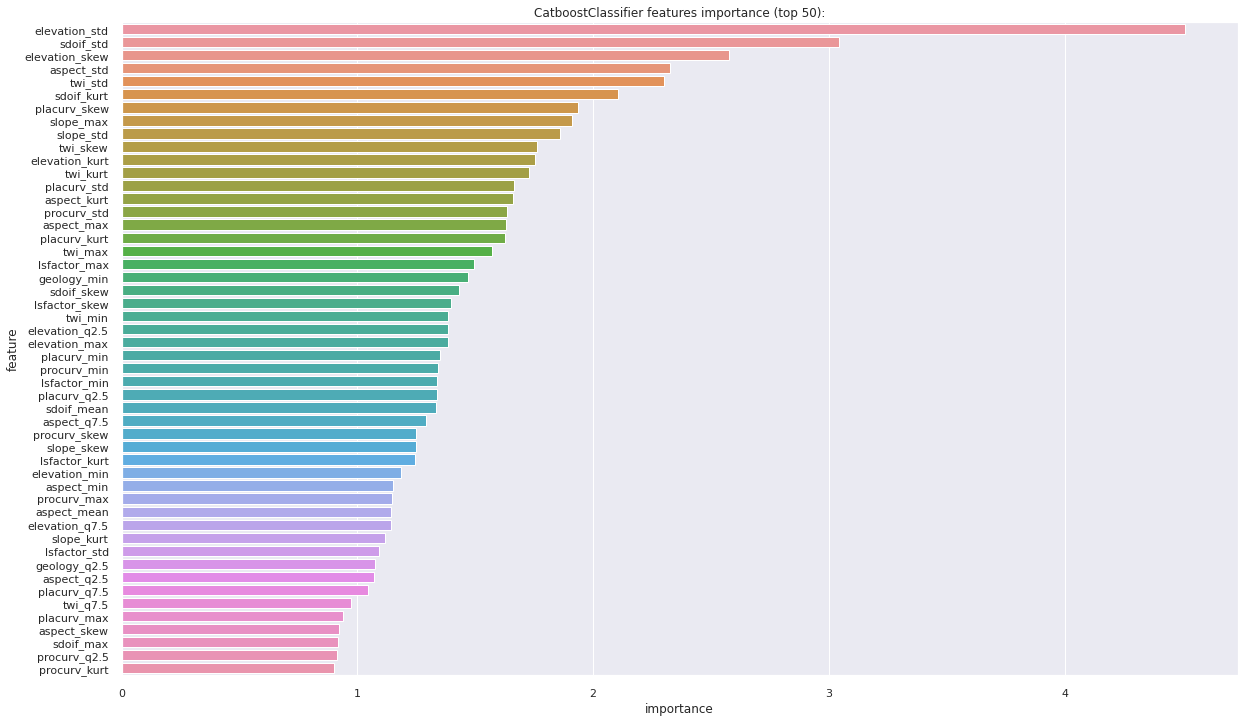

In [96]:
feature_importance_df = pd.DataFrame(m2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

In [97]:
GonnaBeDeleted = feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50)
GonnaBeDeleted = GonnaBeDeleted['feature'].tail(75)
GonnaBeDeleted.tolist()

['elevation_std',
 'sdoif_std',
 'elevation_skew',
 'aspect_std',
 'twi_std',
 'sdoif_kurt',
 'placurv_skew',
 'slope_max',
 'slope_std',
 'twi_skew',
 'elevation_kurt',
 'twi_kurt',
 'placurv_std',
 'aspect_kurt',
 'procurv_std',
 'aspect_max',
 'placurv_kurt',
 'twi_max',
 'lsfactor_max',
 'geology_min',
 'sdoif_skew',
 'lsfactor_skew',
 'twi_min',
 'elevation_q2.5',
 'elevation_max',
 'placurv_min',
 'procurv_min',
 'lsfactor_min',
 'placurv_q2.5',
 'sdoif_mean',
 'aspect_q7.5',
 'procurv_skew',
 'slope_skew',
 'lsfactor_kurt',
 'elevation_min',
 'aspect_min',
 'procurv_max',
 'aspect_mean',
 'elevation_q7.5',
 'slope_kurt',
 'lsfactor_std',
 'geology_q2.5',
 'aspect_q2.5',
 'placurv_q7.5',
 'twi_q7.5',
 'placurv_max',
 'aspect_skew',
 'sdoif_max',
 'procurv_q2.5',
 'procurv_kurt']

In [ ]:
# predictions = pd.DataFrame(y_pred_totcb2)

In [ ]:
# predictions = np.where(np.mean(predictions, axis=0)> 0.30, 1, 0)

In [ ]:
# submission = pd.DataFrame()
# submission['Sample_ID'] = id_
# submission['Label'] = pd.DataFrame(predictions.T)
# submission.to_csv('submission.csv', index=False)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(train["Label"], y_pred_totcb2))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87      8148
           1       0.59      0.85      0.70      2716

    accuracy                           0.81     10864
   macro avg       0.77      0.83      0.78     10864
weighted avg       0.85      0.81      0.82     10864

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      8148
           1       0.58      0.85      0.69      2716

    accuracy                           0.81     10864
   macro avg       0.76      0.82      0.78     10864
weighted avg       0.85      0.81      0.82     10864


In [ ]:
sub=pd.DataFrame({"Sample_ID":id_})
sub['Label']=(np.round((tstpred)))
sub
sub.Label.value_counts()
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv",index=False)
    return FileLink(submission_name+".csv")
create_submission(submission, "sol")

#### 